In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [2]:
np.random.seed(60)

# Feature Extraction and Preprocessing

In [3]:
# Function to extract features from an audio file
def extract_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=44100)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

# Function to load data from a directory
def load_data(data_dir, n_mfcc=20):
    data = []
    for accent in os.listdir(data_dir):
        accent_dir = os.path.join(data_dir, accent)
        if os.path.isdir(accent_dir):
            for file in os.listdir(accent_dir):
                file_path = os.path.join(accent_dir, file)
                if file_path.endswith('.wav'):
                    features = extract_features(file_path, n_mfcc)
                    data.append(np.append(features, accent))
    return pd.DataFrame(data, columns=[f'mfcc_{i}' for i in range(n_mfcc)] + ['label'])

# Function for Feature Perturbation
def augment_data(df, num_augmentations=2, perturbation_factor=0.01):
    augmented_data = []
    features = df.iloc[:, :-1].values.astype(float)
    labels = df['label'].values
    
    for i in range(len(df)):
        original_features = features[i]
        label = labels[i]
        augmented_data.append(np.append(original_features, label))
        for _ in range(num_augmentations):
            perturbed_features = original_features + np.random.normal(0, perturbation_factor, original_features.shape)
            augmented_data.append(np.append(perturbed_features, label))
            
    augmented_df = pd.DataFrame(augmented_data, columns=df.columns)
    return augmented_df

In [4]:
# Load training and validation data
train_data_dir = '../PS_Accents'
train_df = load_data(train_data_dir)

In [5]:
train_df = augment_data(train_df, num_augmentations=5, perturbation_factor=0.01)

In [6]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(train_df.iloc[:, :-1].values)
y = train_df['label'].values

In [7]:
# Split the dataset into training and validation sets
X_train = X
y_train = y

In [8]:
# Load and normalize test data
test_data_dir = '../testing data'
test_df = load_data(test_data_dir)
X_test = scaler.transform(test_df.iloc[:, :-1].values)
y_test = test_df['label'].values

# Using KNN Model

In [9]:
# Set up the parameter grid for grid search
param_grid = {
    'n_neighbors': [1, 2, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],  # Relevant for ball_tree and kd_tree algorithms
    # 'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [10]:
# Initialize k-NN classifier
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50],
                         'n_neighbors': [1, 2, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [11]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 1, 'weights': 'uniform'}


# KNN Model Evaluation

In [12]:
# Predictions
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

In [13]:
# Evaluate
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [14]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Training Accuracy: 1.0
Testing Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

       Hebron       1.00      0.60      0.75         5
    Jerusalem       0.56      1.00      0.71         5
       Nablus       1.00      0.60      0.75         5
Ramallah_Reef       0.80      0.80      0.80         5

     accuracy                           0.75        20
    macro avg       0.84      0.75      0.75        20
 weighted avg       0.84      0.75      0.75        20



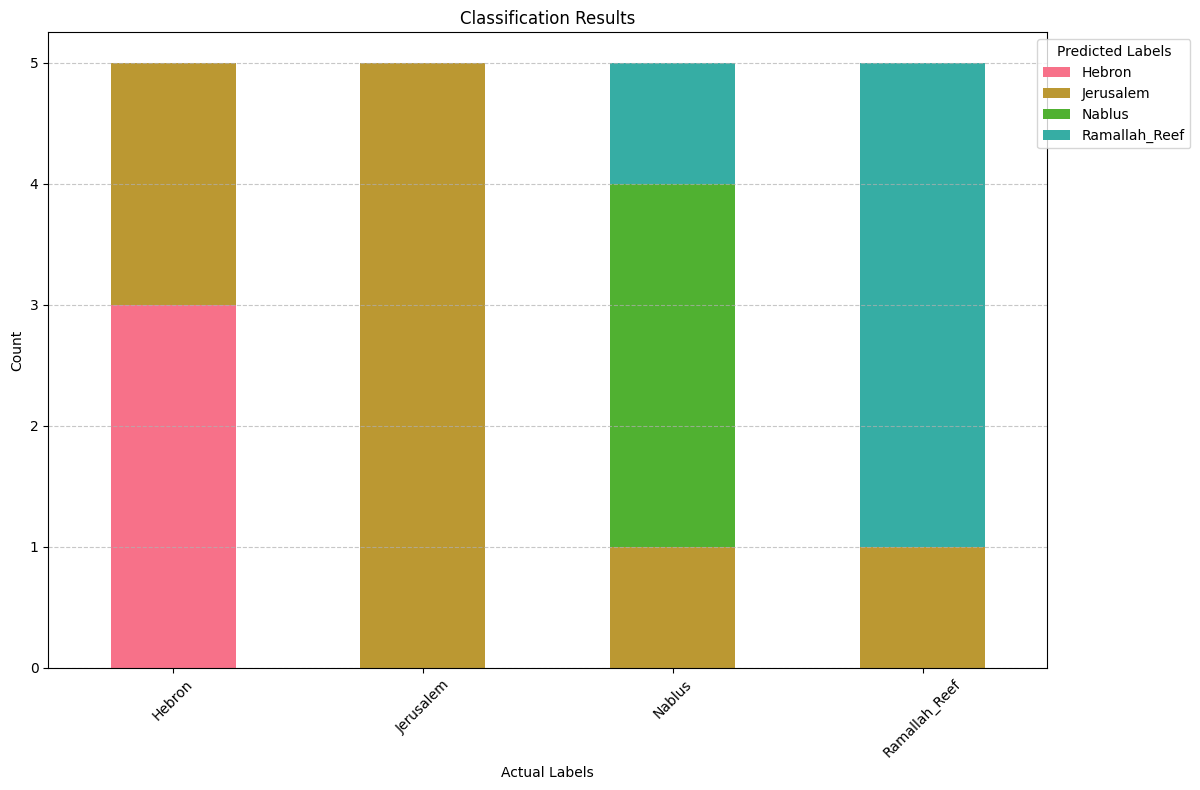

In [15]:
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

# Set the color palette
palette = sns.color_palette("husl")

# Group data by actual and predicted labels
grouped_results = test_results.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
grouped_results.plot(kind='bar', stacked=True, ax=ax, color=palette)
plt.title('Classification Results')
plt.xlabel('Actual Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Predicted Labels', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Using MLP Model 

In [24]:
# Set up the parameter grid for MLP
param_grid = {
    'hidden_layer_sizes': [(50, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['constant'],
}

In [25]:
mlp = MLPClassifier(max_iter=300)

In [26]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1)

In [27]:
# Perform GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=300), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.05],
                         'hidden_layer_sizes': [(50, 50)],
                         'learning_rate': ['constant'], 'solver': ['adam']})

In [28]:
# Best Parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}

In [29]:
# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


# MLP Model Evaluation

In [30]:
# Predictions
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

In [31]:
# Evaluate
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [32]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Training Accuracy: 1.0
Testing Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

       Hebron       1.00      1.00      1.00         5
    Jerusalem       0.83      1.00      0.91         5
       Nablus       1.00      0.40      0.57         5
Ramallah_Reef       0.71      1.00      0.83         5

     accuracy                           0.85        20
    macro avg       0.89      0.85      0.83        20
 weighted avg       0.89      0.85      0.83        20



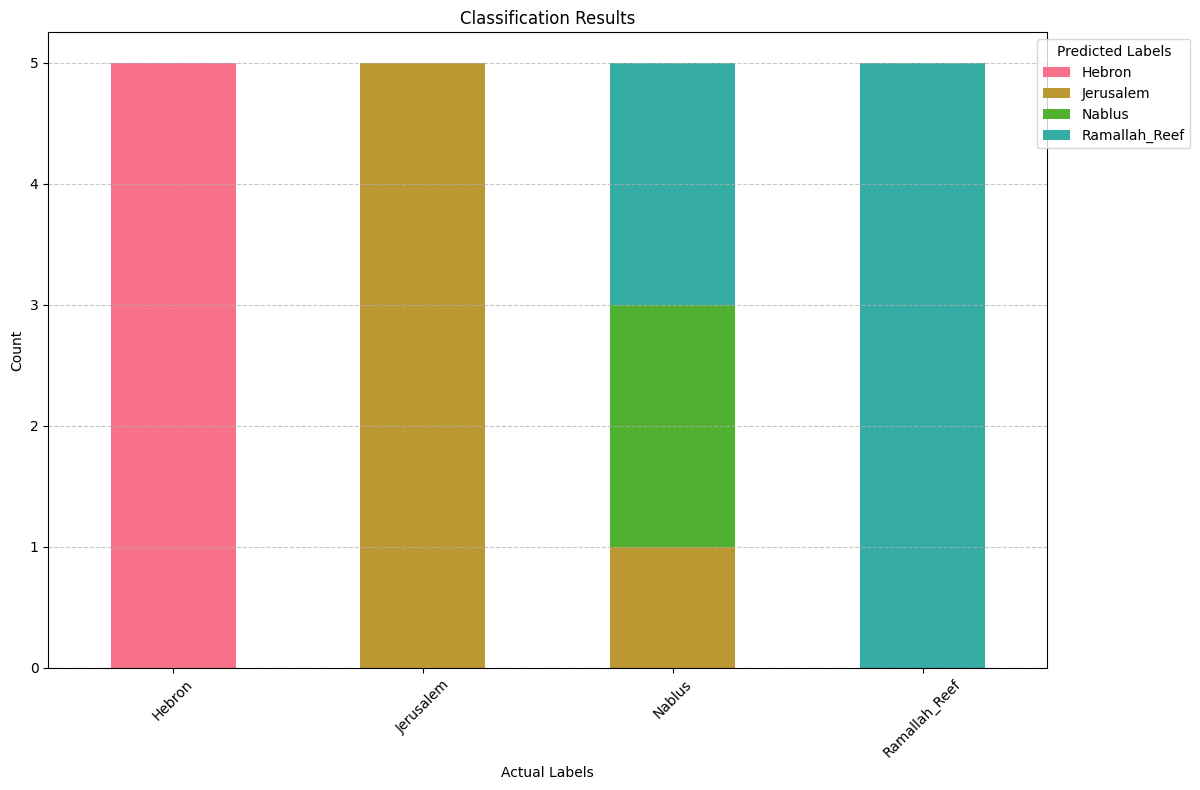

In [33]:
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

# Set the color palette
palette = sns.color_palette("husl")

# Group data by actual and predicted labels
grouped_results = test_results.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
grouped_results.plot(kind='bar', stacked=True, ax=ax, color=palette)
plt.title('Classification Results')
plt.xlabel('Actual Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Predicted Labels', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()